# ◆House Prices: Advanced Regression Techniques
### 目的：住宅価格を予測する
### 目的変数をSalePriceとする回帰問題として、Lasso回帰モデルを構築する
- kaggle URL:https://www.kaggle.com/c/house-prices-advanced-regression-techniques
- Create Date：2020/01/05　Author：M.Hasegawa
### ────────────────────────────────────────────────────────────────

### 【手順】

### 0.Notebook内で利用する関数の定義

### 1.データ読込
- 欠損項目を確認する

### 2.データ前処理
- 事前に予測できない項目は、除外する。
- 目的変数を説明するのに有効そうな説明変数を見つける。
- 目的変数と説明変数の関係を確認するためのグラフを作成する。
- 質的変数が扱えない場合は、ダミー変数に置き換える。

### 3.モデル構築
- Lasso回帰モデルを利用する

### 4.モデル検証
- MSE,RMSE,MAEを求める

### 5.予測結果提出

### ※データセット
- 「train.csv」（学習データ数：1460行81列）
- 「test.csv」（テストデータ数：1459行80列 ※SalePriceがない）

## 0.Notebook内で利用する関数の定義

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error # 回帰問題における性能評価に関する関数
from sklearn.metrics import log_loss, accuracy_score, confusion_matrix,precision_recall_fscore_support
from sklearn.linear_model import (LinearRegression,Ridge,Lasso)
# 警告非表示
import warnings
warnings.filterwarnings('ignore')

## 1.データ読込

In [2]:
# ****************************************************************************
# ◆ 1.データ読込
# ****************************************************************************

# データの読み込み
train = pd.read_csv('./input/train.csv') #訓練データ
test = pd.read_csv('./input/test.csv') #テストデータ

print('The size of train is : ' + str(train.shape))
print('The size of test is : ' + str(test.shape))

print("\n▼ 先頭5行表示")
pd.set_option('display.max_columns', 400)
display(train.head(5))

# 学習データとテストデータのマージ
train['tag'] = 'Train'
test['tag'] = 'Test'
test['SalePrice'] = 9999999999

all_df = pd.concat([train,test],axis=0).reset_index(drop=True)

# 欠損状況確認
#print('\n ▼ trainデータの欠損状況 ')
#display(train.isnull().sum()[train.isnull().sum()>0].sort_values(ascending=False))

#print('\n ▼ testデータの欠損状況 ')
#display(test.isnull().sum()[test.isnull().sum()>0].sort_values(ascending=False))

# 欠損を含むカラムのリスト表示
na_col_list = all_df.isnull().sum()[all_df.isnull().sum()>0].index.tolist() 

print('\n ▼ 欠損を含むカラムの型リスト表示 ')
display(all_df[na_col_list].dtypes.sort_values()) 

The size of train is : (1460, 81)
The size of test is : (1459, 80)

▼ 先頭5行表示


,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,Ex,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,2003.0,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,Ex,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,Ex,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,Gd,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.0,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,Ex,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.0,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000



 ▼ 欠損を含むカラムの型リスト表示 


MasVnrArea      float64
GarageArea      float64
TotalBsmtSF     float64
BsmtFinSF1      float64
BsmtFinSF2      float64
GarageYrBlt     float64
BsmtFullBath    float64
BsmtHalfBath    float64
GarageCars      float64
BsmtUnfSF       float64
LotFrontage     float64
GarageType       object
KitchenQual      object
Alley            object
MasVnrType       object
MiscFeature      object
PoolQC           object
SaleType         object
MSZoning         object
GarageQual       object
Functional       object
GarageCond       object
FireplaceQu      object
Fence            object
Exterior2nd      object
Exterior1st      object
Electrical       object
BsmtQual         object
BsmtFinType2     object
BsmtFinType1     object
BsmtExposure     object
BsmtCond         object
GarageFinish     object
Utilities        object
dtype: object

## 2.データ前処理

In [3]:
# ****************************************************************************
# ◆ 2.前処理
# ****************************************************************************
# ------------------------------------------------
# 2-1.欠損値の補完
# ------------------------------------------------
# object変数の欠損：欠損を示す文字列’NA’を補完
# 数値型変数の欠損：0.0を補完

# float64リスト
na_float_cols = all_df[na_col_list].dtypes[all_df[na_col_list].dtypes=='float64'].index.tolist()

# objectリスト
na_obj_cols = all_df[na_col_list].dtypes[all_df[na_col_list].dtypes=='object'].index.tolist()

print('\n▼ 数値型欠損カラム----> 0.0 を補完：\n',na_float_cols)
print('\n▼ object型欠損カラム----> NA を補完：\n',na_obj_cols)

# float64型で欠損している場合は0を代入
for na_float_col in na_float_cols:
    all_df.loc[all_df[na_float_col].isnull(),na_float_col] = 0.0

# object型で欠損している場合は'NA'を代入
for na_obj_col in na_obj_cols:
    all_df.loc[all_df[na_obj_col].isnull(),na_obj_col] = 'NA'

#print('\n ▼ 欠損を含むカラムの型リスト表示 ')
#na_col_list = all_df.isnull().sum()[all_df.isnull().sum()>0].index.tolist() 
#display(all_df[na_col_list].dtypes.sort_values()) 


▼ 数値型欠損カラム----> 0.0 を補完：
 ['BsmtFinSF1', 'BsmtFinSF2', 'BsmtFullBath', 'BsmtHalfBath', 'BsmtUnfSF', 'GarageArea', 'GarageCars', 'GarageYrBlt', 'LotFrontage', 'MasVnrArea', 'TotalBsmtSF']

▼ object型欠損カラム----> NA を補完：
 ['Alley', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'BsmtQual', 'Electrical', 'Exterior1st', 'Exterior2nd', 'Fence', 'FireplaceQu', 'Functional', 'GarageCond', 'GarageFinish', 'GarageQual', 'GarageType', 'KitchenQual', 'MSZoning', 'MasVnrType', 'MiscFeature', 'PoolQC', 'SaleType', 'Utilities']


In [4]:
# ------------------------------------------------
# 2-2.ダミー変換
# ------------------------------------------------

# object変数の特徴量をリスト化
cat_cols = all_df.dtypes[all_df.dtypes=='object'].index.tolist()

# 数値変数の特徴量をリスト化
num_cols = all_df.dtypes[all_df.dtypes!='object'].index.tolist()

# データ分割および提出時に必要なカラムをリスト化
other_cols = ['Id','tag']

# 余計な要素をリストから削除
cat_cols.remove('tag') #区別タグ除外
num_cols.remove('Id') #Id削除

# object変数をダミー化
alldata_cat = pd.get_dummies(all_df[cat_cols])

display(alldata_cat.head(5))

# データ統合
all_data = pd.concat([all_df[other_cols],all_df[num_cols],alldata_cat],axis=1)

display(all_data.head(5))


,Alley_Grvl,Alley_NA,Alley_Pave,BldgType_1Fam,BldgType_2fmCon,BldgType_Duplex,BldgType_Twnhs,BldgType_TwnhsE,BsmtCond_Fa,BsmtCond_Gd,BsmtCond_NA,BsmtCond_Po,BsmtCond_TA,BsmtExposure_Av,BsmtExposure_Gd,BsmtExposure_Mn,BsmtExposure_NA,BsmtExposure_No,BsmtFinType1_ALQ,BsmtFinType1_BLQ,BsmtFinType1_GLQ,BsmtFinType1_LwQ,BsmtFinType1_NA,BsmtFinType1_Rec,BsmtFinType1_Unf,BsmtFinType2_ALQ,BsmtFinType2_BLQ,BsmtFinType2_GLQ,BsmtFinType2_LwQ,BsmtFinType2_NA,BsmtFinType2_Rec,BsmtFinType2_Unf,BsmtQual_Ex,BsmtQual_Fa,BsmtQual_Gd,BsmtQual_NA,BsmtQual_TA,CentralAir_N,CentralAir_Y,Condition1_Artery,Condition1_Feedr,Condition1_Norm,Condition1_PosA,Condition1_PosN,Condition1_RRAe,Condition1_RRAn,Condition1_RRNe,Condition1_RRNn,Condition2_Artery,Condition2_Feedr,Condition2_Norm,Condition2_PosA,Condition2_PosN,Condition2_RRAe,Condition2_RRAn,Condition2_RRNn,Electrical_FuseA,Electrical_FuseF,Electrical_FuseP,Electrical_Mix,Electrical_NA,Electrical_SBrkr,ExterCond_Ex,ExterCond_Fa,ExterCond_Gd,ExterCond_Po,ExterCond_TA,ExterQual_Ex,ExterQual_Fa,ExterQual_Gd,ExterQual_TA,Exterior1st_AsbShng,Exterior1st_AsphShn,Exterior1st_BrkComm,Exterior1st_BrkFace,Exterior1st_CBlock,Exterior1st_CemntBd,Exterior1st_HdBoard,Exterior1st_ImStucc,Exterior1st_MetalSd,Exterior1st_NA,Exterior1st_Plywood,Exterior1st_Stone,Exterior1st_Stucco,Exterior1st_VinylSd,Exterior1st_Wd Sdng,Exterior1st_WdShing,Exterior2nd_AsbShng,Exterior2nd_AsphShn,Exterior2nd_Brk Cmn,Exterior2nd_BrkFace,Exterior2nd_CBlock,Exterior2nd_CmentBd,Exterior2nd_HdBoard,Exterior2nd_ImStucc,Exterior2nd_MetalSd,Exterior2nd_NA,Exterior2nd_Other,Exterior2nd_Plywood,Exterior2nd_Stone,Exterior2nd_Stucco,Exterior2nd_VinylSd,Exterior2nd_Wd Sdng,Exterior2nd_Wd Shng,Fence_GdPrv,Fence_GdWo,Fence_MnPrv,Fence_MnWw,Fence_NA,FireplaceQu_Ex,FireplaceQu_Fa,FireplaceQu_Gd,FireplaceQu_NA,FireplaceQu_Po,FireplaceQu_TA,Foundation_BrkTil,Foundation_CBlock,Foundation_PConc,Foundation_Slab,Foundation_Stone,Foundation_Wood,Functional_Maj1,Functional_Maj2,Functional_Min1,Functional_Min2,Functional_Mod,Functional_NA,Functional_Sev,Functional_Typ,GarageCond_Ex,GarageCond_Fa,GarageCond_Gd,GarageCond_NA,GarageCond_Po,GarageCond_TA,GarageFinish_Fin,GarageFinish_NA,GarageFinish_RFn,GarageFinish_Unf,GarageQual_Ex,GarageQual_Fa,GarageQual_Gd,GarageQual_NA,GarageQual_Po,GarageQual_TA,GarageType_2Types,GarageType_Attchd,GarageType_Basment,GarageType_BuiltIn,GarageType_CarPort,GarageType_Detchd,GarageType_NA,Heating_Floor,Heating_GasA,Heating_GasW,Heating_Grav,Heating_OthW,Heating_Wall,HeatingQC_Ex,HeatingQC_Fa,HeatingQC_Gd,HeatingQC_Po,HeatingQC_TA,HouseStyle_1.5Fin,HouseStyle_1.5Unf,HouseStyle_1Story,HouseStyle_2.5Fin,HouseStyle_2.5Unf,HouseStyle_2Story,HouseStyle_SFoyer,HouseStyle_SLvl,KitchenQual_Ex,KitchenQual_Fa,KitchenQual_Gd,KitchenQual_NA,KitchenQual_TA,LandContour_Bnk,LandContour_HLS,LandContour_Low,LandContour_Lvl,LandSlope_Gtl,LandSlope_Mod,LandSlope_Sev,LotConfig_Corner,LotConfig_CulDSac,LotConfig_FR2,LotConfig_FR3,LotConfig_Inside,LotShape_IR1,LotShape_IR2,LotShape_IR3,LotShape_Reg,MSZoning_C (all),MSZoning_FV,MSZoning_NA,MSZoning_RH,MSZoning_RL,MSZoning_RM,MasVnrType_BrkCmn,MasVnrType_BrkFace,MasVnrType_NA,MasVnrType_None,MasVnrType_Stone,MiscFeature_Gar2,MiscFeature_NA,MiscFeature_Othr,MiscFeature_Shed,MiscFeature_TenC,Neighborhood_Blmngtn,Neighborhood_Blueste,Neighborhood_BrDale,Neighborhood_BrkSide,Neighborhood_ClearCr,Neighborhood_CollgCr,Neighborhood_Crawfor,Neighborhood_Edwards,Neighborhood_Gilbert,Neighborhood_IDOTRR,Neighborhood_MeadowV,Neighborhood_Mitchel,Neighborhood_NAmes,Neighborhood_NPkVill,Neighborhood_NWAmes,Neighborhood_NoRidge,Neighborhood_NridgHt,Neighborhood_OldTown,Neighborhood_SWISU,Neighborhood_Sawyer,Neighborhood_SawyerW,Neighborhood_Somerst,Neighborhood_StoneBr,Neighborhood_Timber,Neighborhood_Veenker,PavedDrive_N,PavedDrive_P,PavedDrive_Y,PoolQC_Ex,PoolQC_Fa,PoolQC_Gd,PoolQC_NA,RoofMatl_ClyTile,RoofMatl_CompShg,RoofMatl_Membran,RoofMatl_Metal,RoofMatl_Roll,RoofMatl_Tar&Grv,RoofMatl_WdShake,RoofMatl_WdShng

,Id,tag,1stFlrSF,2ndFlrSF,3SsnPorch,BedroomAbvGr,BsmtFinSF1,BsmtFinSF2,BsmtFullBath,BsmtHalfBath,BsmtUnfSF,EnclosedPorch,Fireplaces,FullBath,GarageArea,GarageCars,GarageYrBlt,GrLivArea,HalfBath,KitchenAbvGr,LotArea,LotFrontage,LowQualFinSF,MSSubClass,MasVnrArea,MiscVal,MoSold,OpenPorchSF,OverallCond,OverallQual,PoolArea,SalePrice,ScreenPorch,TotRmsAbvGrd,TotalBsmtSF,WoodDeckSF,YearBuilt,YearRemodAdd,YrSold,Alley_Grvl,Alley_NA,Alley_Pave,BldgType_1Fam,BldgType_2fmCon,BldgType_Duplex,BldgType_Twnhs,BldgType_TwnhsE,BsmtCond_Fa,BsmtCond_Gd,BsmtCond_NA,BsmtCond_Po,BsmtCond_TA,BsmtExposure_Av,BsmtExposure_Gd,BsmtExposure_Mn,BsmtExposure_NA,BsmtExposure_No,BsmtFinType1_ALQ,BsmtFinType1_BLQ,BsmtFinType1_GLQ,BsmtFinType1_LwQ,BsmtFinType1_NA,BsmtFinType1_Rec,BsmtFinType1_Unf,BsmtFinType2_ALQ,BsmtFinType2_BLQ,BsmtFinType2_GLQ,BsmtFinType2_LwQ,BsmtFinType2_NA,BsmtFinType2_Rec,BsmtFinType2_Unf,BsmtQual_Ex,BsmtQual_Fa,BsmtQual_Gd,BsmtQual_NA,BsmtQual_TA,CentralAir_N,CentralAir_Y,Condition1_Artery,Condition1_Feedr,Condition1_Norm,Condition1_PosA,Condition1_PosN,Condition1_RRAe,Condition1_RRAn,Condition1_RRNe,Condition1_RRNn,Condition2_Artery,Condition2_Feedr,Condition2_Norm,Condition2_PosA,Condition2_PosN,Condition2_RRAe,Condition2_RRAn,Condition2_RRNn,Electrical_FuseA,Electrical_FuseF,Electrical_FuseP,Electrical_Mix,Electrical_NA,Electrical_SBrkr,ExterCond_Ex,ExterCond_Fa,ExterCond_Gd,ExterCond_Po,ExterCond_TA,ExterQual_Ex,ExterQual_Fa,ExterQual_Gd,ExterQual_TA,Exterior1st_AsbShng,Exterior1st_AsphShn,Exterior1st_BrkComm,Exterior1st_BrkFace,Exterior1st_CBlock,Exterior1st_CemntBd,Exterior1st_HdBoard,Exterior1st_ImStucc,Exterior1st_MetalSd,Exterior1st_NA,Exterior1st_Plywood,Exterior1st_Stone,Exterior1st_Stucco,Exterior1st_VinylSd,Exterior1st_Wd Sdng,Exterior1st_WdShing,Exterior2nd_AsbShng,Exterior2nd_AsphShn,Exterior2nd_Brk Cmn,Exterior2nd_BrkFace,Exterior2nd_CBlock,Exterior2nd_CmentBd,Exterior2nd_HdBoard,Exterior2nd_ImStucc,Exterior2nd_MetalSd,Exterior2nd_NA,Exterior2nd_Other,Exterior2nd_Plywood,Exterior2nd_Stone,Exterior2nd_Stucco,Exterior2nd_VinylSd,Exterior2nd_Wd Sdng,Exterior2nd_Wd Shng,Fence_GdPrv,Fence_GdWo,Fence_MnPrv,Fence_MnWw,Fence_NA,FireplaceQu_Ex,FireplaceQu_Fa,FireplaceQu_Gd,FireplaceQu_NA,FireplaceQu_Po,FireplaceQu_TA,Foundation_BrkTil,Foundation_CBlock,Foundation_PConc,Foundation_Slab,Foundation_Stone,Foundation_Wood,Functional_Maj1,Functional_Maj2,Functional_Min1,Functional_Min2,Functional_Mod,Functional_NA,Functional_Sev,Functional_Typ,GarageCond_Ex,GarageCond_Fa,GarageCond_Gd,GarageCond_NA,GarageCond_Po,GarageCond_TA,GarageFinish_Fin,GarageFinish_NA,GarageFinish_RFn,GarageFinish_Unf,GarageQual_Ex,GarageQual_Fa,GarageQual_Gd,GarageQual_NA,GarageQual_Po,GarageQual_TA,GarageType_2Types,GarageType_Attchd,GarageType_Basment,GarageType_BuiltIn,GarageType_CarPort,GarageType_Detchd,GarageType_NA,Heating_Floor,Heating_GasA,Heating_GasW,Heating_Grav,Heating_OthW,Heating_Wall,HeatingQC_Ex,HeatingQC_Fa,HeatingQC_Gd,HeatingQC_Po,HeatingQC_TA,HouseStyle_1.5Fin,HouseStyle_1.5Unf,HouseStyle_1Story,HouseStyle_2.5Fin,HouseStyle_2.5Unf,HouseStyle_2Story,HouseStyle_SFoyer,HouseStyle_SLvl,KitchenQual_Ex,KitchenQual_Fa,KitchenQual_Gd,KitchenQual_NA,KitchenQual_TA,LandContour_Bnk,LandContour_HLS,LandContour_Low,LandContour_Lvl,LandSlope_Gtl,LandSlope_Mod,LandSlope_Sev,LotConfig_Corner,LotConfig_CulDSac,LotConfig_FR2,LotConfig_FR3,LotConfig_Inside,LotShape_IR1,LotShape_IR2,LotShape_IR3,LotShape_Reg,MSZoning_C (all),MSZoning_FV,MSZoning_NA,MSZoning_RH,MSZoning_RL,MSZoning_RM,MasVnrType_BrkCmn,MasVnrType_BrkFace,MasVnrType_NA,MasVnrType_None,MasVnrType_Stone,MiscFeature_Gar2,MiscFeature_NA,MiscFeature_Othr,MiscFeature_Shed,MiscFeature_TenC,Neighborhood_Blmngtn,Neighborhood_Blueste,Neighborhood_BrDale,Neighborhood_BrkSide,Neighborhood_ClearCr,Neighborhood_CollgCr,Neighborhood_Crawfor,Neighborhood_Edwards,Neighborhood_Gilbert,Neighborhood_IDOTRR,Neighborhood_MeadowV,Neighborhood_Mitchel,Neighborhood_NAmes,Neighborhood_NPkVill,Neighborhood_NWAmes,Neigh


▼ SalePrice(住宅価格)の分布を確認


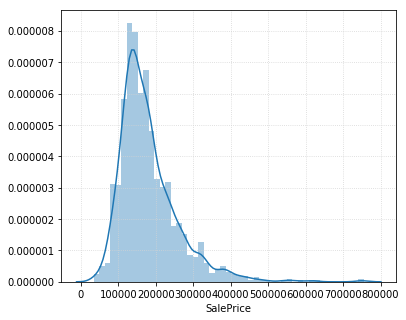

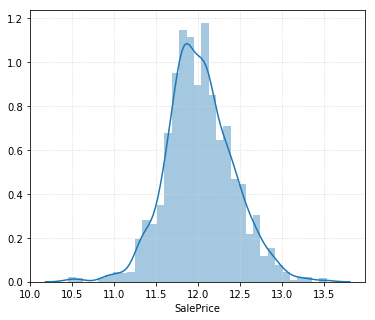

In [5]:
# 目的変数のヒストグラムを表示
print('\n▼ SalePrice(住宅価格)の分布を確認')
plt.figure(figsize=(6,5))
sns.distplot(train['SalePrice'])
plt.grid(which='major',color='lightgray',linestyle=':')
plt.grid(which='minor',color='lightgray',linestyle=':')
plt.show()

# 対数変換
plt.figure(figsize=(6,5))
plt.grid(which='major',color='lightgray',linestyle=':')
plt.grid(which='minor',color='lightgray',linestyle=':')
sns.distplot(np.log(train['SalePrice']))
plt.show()


In [6]:
# マージデータを学習データとテストデータに分割
train_ = all_data[all_data['tag']=='Train'].drop(['tag','Id'], axis=1).reset_index(drop=True)
test_ = all_data[all_data['tag']=='Test'].drop(['tag','SalePrice'], axis=1).reset_index(drop=True)

# 学習データ内の分割
train_x = train_.drop('SalePrice',axis=1)
train_y = np.log(train_['SalePrice'])

# テストデータ内の分割
test_id = test_['Id']
test_data = test_.drop('Id',axis=1)

## 3.モデル構築

In [7]:
scaler = StandardScaler()  #スケーリング
param_grid = [0.001, 0.01, 0.1, 1.0, 10.0,100.0,1000.0] #パラメータグリッド
cnt = 0

# パラメータでループ
for alpha in param_grid:

    #Lasso回帰モデル
    ls = Lasso(alpha=alpha)
    
    #パイプライン生成
    pipeline = make_pipeline(scaler, ls)
    
    # ホールドアウト法
    X_train, X_test, y_train, y_test = train_test_split(train_x, train_y, test_size=0.3, random_state=0)
    
    # 学習
    pipeline.fit(X_train,y_train)
    
    # 学習データのRMSE
    train_rmse = np.sqrt(mean_squared_error(y_train, pipeline.predict(X_train)))
    
    # テストデータのRMSE
    test_rmse = np.sqrt(mean_squared_error(y_test, pipeline.predict(X_test)))

    #print('\n▼ ' + str(cnt) + '回目')
    #print('alpha : ' + str(alpha))
    #print('test_rmse : ' + str(test_rmse))
    #print('estimator : ' + str(pipeline))
    
    if cnt == 0:
        best_score = test_rmse
        best_estimator = pipeline
        best_param = alpha
    elif best_score > test_rmse:
        # より小さいRMSEを見つけた場合
        best_score = test_rmse
        best_estimator = pipeline
        best_param = alpha
    else:
        pass
    cnt = cnt + 1
    
print('\n▼ ベストスコア')
print('alpha : ' + str(best_param))
print('test score is : ' +str(best_score))


▼ ベストスコア
alpha : 0.01
test score is : 0.1807369087214937


## 4.モデルの検証


▼ モデルの検証


<Figure size 432x288 with 0 Axes>

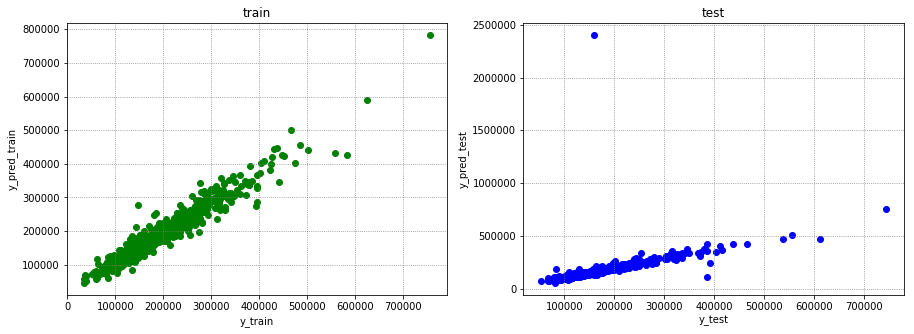

In [8]:
# ****************************************************************************
# ◆ 4.モデルの検証
# ****************************************************************************
print('\n▼ モデルの検証')
# 学習したモデルが実際に教師データにどれくらい近似できているのか
# 横軸が教師データ、縦軸が予測結果としてデータを散布
plt.subplots_adjust(wspace=0.8) # 余白
plt.figure(figsize=(15,5))

# 学習データ
plt.subplot(121) # plt.subplot(行数, 列数, 何番目のプロットか)
# 学習データ（正解、予測結果）
plt.scatter(np.exp(y_train), np.exp(best_estimator.predict(X_train)), c='green')
plt.title('train')
plt.xlabel('y_train')
plt.ylabel('y_pred_train')
plt.grid(which='major',color='gray',linestyle=':')
plt.grid(which='minor',color='gray',linestyle=':')

# テストデータ
plt.subplot(122) # plt.subplot(行数, 列数, 何番目のプロットか)
#テストデータ（正解、予測結果）
plt.scatter(np.exp(y_test), np.exp(best_estimator.predict(X_test)), c='blue')
plt.title('test')
plt.xlabel('y_test')
plt.ylabel('y_pred_test')
plt.grid(which='major',color='gray',linestyle=':')
plt.grid(which='minor',color='gray',linestyle=':')


## 5.予測結果の出力

In [9]:
# test_id
ls = Lasso(alpha = 0.01)
pipeline = make_pipeline(scaler, ls)

# 予測
pipeline.fit(train_x,train_y)

# 予測結果のSalePrice(住宅価格)は対数をとった値なので、最終的にはexponentialをかける
test_SalePrice = pd.DataFrame(np.exp(pipeline.predict(test_data)),columns=['SalePrice'])

test_Id = pd.DataFrame(test_id,columns=['Id'])

pd.concat([test_Id, test_SalePrice],axis=1).to_csv('./output/submission_Lasso.csv',index=False)